In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import shutil
import math
import random
import heapq 
import time
import copy
import itertools  
from PIL import Image
from io import StringIO,BytesIO 
from scipy.spatial.distance import pdist
import cv2
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,auc 
from functools import reduce
import wfdb#https://github.com/MIT-LCP/wfdb-python
from wfdb import processing
import faiss 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
torch.cuda.set_device(1)
print (torch.cuda.current_device())

Loading faiss with AVX2 support.


1


In [2]:
#read train image with CV
train_dir = '/data/fjsdata/ECG/MIT-BIH/train' #the path of images
trI, trY = [],[]
for iname in os.listdir(train_dir):
    if iname.endswith(".png"):
        try:
            image_path = os.path.join(train_dir, iname)
            itype = int(os.path.splitext(iname)[0].split("-")[1])
            img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(500,300,3)->(256,256,3)
            trI.append(img)
            trY.append(itype)
        except:
            print(iname+":"+str(image_path))
        sys.stdout.write('\r{} / {} '.format(len(trY),20000))
        sys.stdout.flush()
print('The length of train set is %d'%len(trY))
#read test image with CV
test_dir = '/data/fjsdata/ECG/MIT-BIH/test' #the path of images
teI, teY = [],[]
for iname in os.listdir(test_dir):
    if iname.endswith(".png"):
        try:
            image_path = os.path.join(test_dir, iname)
            itype = int(os.path.splitext(iname)[0].split("-")[1])
            img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(500,300,3)->(256,256,3)
            teI.append(img)
            teY.append(itype)
        except:
            print(iname+":"+str(image_path))
        sys.stdout.write('\r{} / {} '.format(len(teY),20000))
        sys.stdout.flush()
print('The length of test set is %d'%len(teY))

20000 / 20000 The length of train set is 20000
20000 / 20000 The length of test set is 20000


In [9]:
#ATH model with Tripet loss
class SpatialAttention(nn.Module):#spatial attention layer
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True) #resnet

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ATHNet(nn.Module):
    def __init__(self, code_size: int):
        super().__init__()
        #resnet and maxpool
        self.net1 = nn.Sequential(#(3,256,256)->(16,128,128)
            ResBlock(in_channels=3, out_channels=16, stride=2), 
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
        )
        
        #Attention (16,128,128)->(16,128,128)
        self.sa = SpatialAttention()
        
        #resnet and meanpool
        self.net2 =nn.Sequential( #(16,128,128)->(8,64,64)
            ResBlock(in_channels=16, out_channels=8, stride=2),
            nn.AvgPool2d(kernel_size=3, padding=1, stride=1)
        ) 
         
        #fully connected with conv (8,64,64)->(1,32,32)
        self.dense=ResBlock(in_channels=8, out_channels=1, stride=2)
        #fully connected (1,32,32)->class_size
        self.linear = nn.Linear(1*32*32, code_size)
    
        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.net1(x)
        x = self.sa(x)*x
        x = self.net2(x)
        x = self.dense(x)
        x = x.view(x.size(0),-1)
        x = self.linear(x)
        return x

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)

#https://github.com/luyajie/triplet-deep-hash-pytorch#triplet-deep-hash-pytorch            
class TripletLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(TripletLoss, self).__init__()
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
    
    def forward(self,H_q,H_p,H_n):    
        margin_val = self.margin * H_q.shape[1]
        squared_loss_pos = torch.mean(self.mse_loss(H_q, H_p), dim=1)
        squared_loss_neg = torch.mean(self.mse_loss(H_q, H_n), dim=1)
        zeros = torch.zeros_like(squared_loss_neg)
        loss  = torch.max(zeros, margin_val - squared_loss_neg + squared_loss_pos)
        return torch.mean(loss)
        
#Generate image pairs for model
def onlineGenImgPairs( ):
    idx_sf = []
    idx_0 = np.where( np.array(trY) == 0 ) #class 0
    idx_0 = list(idx_0[0])[0:3555]
    idx_sf.extend(idx_0)
    idx_1 = np.where( np.array(trY) == 1 ) #class 1
    idx_1 = list(idx_1[0])
    idx_sf.extend(idx_1)
    idx_2 = np.where( np.array(trY) == 2 ) #class 2
    idx_2 = list(idx_2[0])
    idx_sf.extend(idx_2)
    idx_3 = np.where( np.array(trY) == 3 ) #class 3
    idx_3 = list(idx_3[0])
    idx_sf.extend(idx_3)
    random.shuffle(idx_sf)   
    trQ_sf, trP_sf, trN_sf = [], [], []
    for iQ in idx_sf:
        trQ_sf.append(trI[iQ])
        if trY[iQ] == 0:
            idx_tmp = idx_0.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_0))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
        elif trY[iQ] == 1:
            idx_tmp = idx_1.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_1))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
        elif trY[iQ] == 2:
            idx_tmp = idx_2.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_2))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
        elif trY[iQ] == 3:
            idx_tmp = idx_3.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_3))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
        else: pass
        sys.stdout.write('\r{} / {} '.format(len(trQ_sf),len(idx_sf)))
        sys.stdout.flush()
    return np.array(trQ_sf),np.array(trP_sf),np.array(trN_sf)
trQ_sf, trP_sf, trN_sf = onlineGenImgPairs() #sample 
assert (trQ_sf.shape==trP_sf.shape)
assert (trQ_sf.shape==trN_sf.shape)

#define model
model = ATHNet(code_size=36).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
criterion  = TripletLoss(margin=0.5).cuda() #define TripletLoss 
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    losses = []
    shuffled_idx = np.random.permutation(np.arange(len(trQ_sf)))
    train_q = trQ_sf[shuffled_idx]
    train_p = trP_sf[shuffled_idx]
    train_n = trN_sf[shuffled_idx]
    num_batches = len(trQ_sf) // batchSize
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trQ_sf), (i+1)*batchSize])
        Q_batch = torch.from_numpy(train_q[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        P_batch = torch.from_numpy(train_p[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        N_batch = torch.from_numpy(train_n[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        #forword
        Q_hash = model(Q_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        P_hash = model(P_batch.permute(0, 3, 1, 2))
        N_hash = model(N_batch.permute(0, 3, 1, 2))
        #binary-like loss
        loss = criterion(Q_hash,P_hash,N_hash)
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
criterion=criterion.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teF = []
num_batches = len(teI) // batchSize 
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(teI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    teF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(36) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
for topk in [10]:#[5,10,15,20]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    scores, neighbors = gpu_index.search(np.array(teF).astype('float32'), k=topk)
    for i, teVal in enumerate(teF):
        stype = teY[i]
        #map_item_score = {}
        #for j, trVal in enumerate(trF):
        #    map_item_score[j] = pdist(np.vstack([teVal,trVal]),'hamming')
        #ranklist = heapq.nsmallest(topk, map_item_score, key=map_item_score.get)
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        #for j in ranklist:
        for j in neighbors[i].tolist():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))
#performance
scores, neighbors = gpu_index.search(np.ascontiguousarray(teF, dtype=np.float32), k=1) #return top1
y_pred = []
for i in neighbors.flatten():
    y_pred.append(np.array(trY)[i]) #label of top1
print ( 'Accuracy: %.6f'%accuracy_score(teY, y_pred))
labels = list(set(teY))
cm = confusion_matrix(teY, y_pred, labels=labels ) #labels=['S','V','F','N']
print (cm)
print ('Specificity of N: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of V: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of F: %.6f'%float(cm[3][3]/np.sum(cm[3])))

 900 / 900 : loss = 0.7526599Eopch:     1 mean_loss = 3.279542
 900 / 900 : loss = 1.8017697Eopch:     2 mean_loss = 1.858025
 900 / 900 : loss = 2.1732753Eopch:     3 mean_loss = 1.474515
 900 / 900 : loss = 0.0212384Eopch:     4 mean_loss = 1.215436
 900 / 900 : loss = 1.1875731Eopch:     5 mean_loss = 0.945706
 900 / 900 : loss = 0.0265131Eopch:     6 mean_loss = 0.829577
 900 / 900 : loss = 0.0873069Eopch:     7 mean_loss = 0.649201
 900 / 900 : loss = 1.3812863Eopch:     8 mean_loss = 0.557864
 900 / 900 : loss = 4.9700554Eopch:     9 mean_loss = 0.477160
 900 / 900 : loss = 0.0365846Eopch:    10 mean_loss = 0.380980
best_loss = 0.380980
 1999 / 2000 Completed buliding index in 1 seconds
mHR@10=0.764585, mAP@10=0.732212, mRR@10=0.922244
Accuracy: 0.771900
[[11720   338  2708    88]
 [  404   277   254     9]
 [  275    53  3419    41]
 [  256     4   132    22]]
Specificity of N: 0.789013
Sensitivity of S: 0.293432
Sensitivity of V: 0.902587
Sensitivity of F: 0.053140


In [5]:
#ATH model with Circle loss
class SpatialAttention(nn.Module):#spatial attention layer
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True) #resnet

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ATHNet(nn.Module):
    def __init__(self, code_size: int):
        super().__init__()
        #resnet and maxpool
        self.net1 = nn.Sequential(#(3,256,256)->(16,128,128)
            ResBlock(in_channels=3, out_channels=16, stride=2), 
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
        )
        
        #Attention (16,128,128)->(16,128,128)
        self.sa = SpatialAttention()
        
        #resnet and meanpool
        self.net2 =nn.Sequential( #(16,128,128)->(8,64,64)
            ResBlock(in_channels=16, out_channels=8, stride=2),
            nn.AvgPool2d(kernel_size=3, padding=1, stride=1)
        ) 
         
        #fully connected with conv (8,64,64)->(1,32,32)
        self.dense=ResBlock(in_channels=8, out_channels=1, stride=2)
        #fully connected (1,32,32)->class_size
        self.linear = nn.Linear(1*32*32, code_size)
    
        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.net1(x)
        x = self.sa(x)*x
        x = self.net2(x)
        x = self.dense(x)
        x = x.view(x.size(0),-1)
        x = self.linear(x)
        return x

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)

#https://github.com/qianjinhao/circle-loss        
class CircleLoss(nn.Module):
    def __init__(self, scale=32, margin=0.25, similarity='cos', **kwargs):
        super(CircleLoss, self).__init__()
        self.scale = scale
        self.margin = margin
        self.similarity = similarity

    def forward(self, feats, labels):
        assert feats.size(0) == labels.size(0), \
            f"feats.size(0): {feats.size(0)} is not equal to labels.size(0): {labels.size(0)}"
        batch_size = feats.size(0)
        if self.similarity == 'dot':
            sim_mat = torch.matmul(feats, torch.t(feats))
        elif self.similarity == 'cos':
            feats = F.normalize(feats)
            sim_mat = feats.mm(feats.t())
        else:
            raise ValueError('This similarity is not implemented.')
        loss = list()
        for i in range(batch_size):
            pos_index = labels == labels[i]
            pos_index[i] = 0
            neg_index = labels != labels[i]
            pos_pair_ = sim_mat[i][pos_index]
            neg_pair_ = sim_mat[i][neg_index]

            alpha_p = torch.relu(-pos_pair_ + 1 + self.margin)
            alpha_n = torch.relu(neg_pair_ + self.margin)
            margin_p = 1 - self.margin
            margin_n = self.margin
            loss_p = torch.sum(torch.exp(-self.scale * alpha_p * (pos_pair_ - margin_p)))
            loss_n = torch.sum(torch.exp(self.scale * alpha_n * (neg_pair_ - margin_n)))
            loss.append(torch.log(1 + loss_p * loss_n))

        loss = sum(loss) / batch_size
        return loss

#define model
model = ATHNet(code_size=36).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
criterion  = CircleLoss().cuda() #define TripletLoss 
#train model
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
trI = np.array(trI)
trY = np.array(trY)
for epoch in range(10):#iteration
    losses = []
    shuffled_idx = np.random.permutation(np.arange(len(trY)))
    train_x = trI[shuffled_idx]
    train_y = trY[shuffled_idx]
    num_batches = len(trY) // batchSize
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY), (i+1)*batchSize])
        x_batch = torch.from_numpy(train_x[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        y_batch = torch.from_numpy(train_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        #forword
        out_batch = model(x_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        loss = criterion(out_batch,y_batch) #F.log_softmax+F.nll_loss
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
criterion=criterion.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teF = []
num_batches = len(teI) // batchSize 
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(teI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    teF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(36) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
for topk in [10]:#[5,10,15,20]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    scores, neighbors = gpu_index.search(np.array(teF).astype('float32'), k=topk)
    for i, teVal in enumerate(teF):
        stype = teY[i]
        #map_item_score = {}
        #for j, trVal in enumerate(trF):
        #    map_item_score[j] = pdist(np.vstack([teVal,trVal]),'hamming')
        #ranklist = heapq.nsmallest(topk, map_item_score, key=map_item_score.get)
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        #for j in ranklist:
        for j in neighbors[i].tolist():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))
#performance
scores, neighbors = gpu_index.search(np.ascontiguousarray(teF, dtype=np.float32), k=1) #return top1
y_pred = []
for i in neighbors.flatten():
    y_pred.append(np.array(trY)[i]) #label of top1
print ( 'Accuracy: %.6f'%accuracy_score(teY, y_pred))
labels = list(set(teY))
cm = confusion_matrix(teY, y_pred, labels=labels ) #labels=['S','V','F','N']
print (cm)
print ('Specificity of N: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of V: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of F: %.6f'%float(cm[3][3]/np.sum(cm[3])))

 2000 / 2000 : loss = 28.791004Eopch:     1 mean_loss = 6.159987
 2000 / 2000 : loss = 2.7728984Eopch:     2 mean_loss = 4.808845
 2000 / 2000 : loss = 1.6849271Eopch:     3 mean_loss = 4.379453
 2000 / 2000 : loss = 5.6150084Eopch:     4 mean_loss = 3.991290
 2000 / 2000 : loss = 0.6212132Eopch:     5 mean_loss = 3.846304
 2000 / 2000 : loss = 0.5954235Eopch:     6 mean_loss = 3.586824
 2000 / 2000 : loss = 4.8045978Eopch:     7 mean_loss = 3.472749
 2000 / 2000 : loss = 0.4357259Eopch:     8 mean_loss = 3.353871
 2000 / 2000 : loss = 1.2116066Eopch:     9 mean_loss = 3.243215
 2000 / 2000 : loss = 0.9735791Eopch:    10 mean_loss = 3.028000
 2000 / 2000 : loss = 0.6151916Eopch:    11 mean_loss = 3.009527
 2000 / 2000 : loss = 1.2834233Eopch:    12 mean_loss = 2.942593
 2000 / 2000 : loss = 2.0537311Eopch:    13 mean_loss = 2.804875
 2000 / 2000 : loss = 0.5884126Eopch:    14 mean_loss = 2.829998
 2000 / 2000 : loss = 0.9374894Eopch:    15 mean_loss = 2.608734
 2000 / 2000 : loss = 3.7

In [14]:
#ATH model with pairwise loss
class SpatialAttention(nn.Module):#spatial attention layer
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True) #resnet

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ATHNet(nn.Module):
    def __init__(self, code_size: int):
        super().__init__()
        #resnet and maxpool
        self.net1 = nn.Sequential(#(3,256,256)->(16,128,128)
            ResBlock(in_channels=3, out_channels=16, stride=2), 
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
        )
        
        #Attention (16,128,128)->(16,128,128)
        self.sa = SpatialAttention()
        
        #resnet and meanpool
        self.net2 =nn.Sequential( #(16,128,128)->(8,64,64)
            ResBlock(in_channels=16, out_channels=8, stride=2),
            nn.AvgPool2d(kernel_size=3, padding=1, stride=1)
        ) 
         
        #fully connected with conv (8,64,64)->(1,32,32)
        self.dense=ResBlock(in_channels=8, out_channels=1, stride=2)
        #fully connected (1,32,32)->class_size
        self.linear = nn.Linear(1*32*32, code_size)
    
        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.net1(x)
        x = self.sa(x)*x
        x = self.net2(x)
        x = self.dense(x)
        x = x.view(x.size(0),-1)
        x = self.linear(x)
        return x

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)

#define loss function:pairwise loss            
class PairwiseLoss(nn.Module):
    def __init__(self, margin=0.5, alpha=0.01):
        super(PairwiseLoss, self).__init__()
        self.alpha = alpha #regularization
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
        self.l1_loss = nn.L1Loss(reduction='mean')
    
    def forward(self,h1,h2,y):    
        margin_val = self.margin * h1.shape[1]
        squared_loss = torch.mean(self.mse_loss(h1, h2), dim=1)
        # T1: 0.5 * (1 - y) * dist(x1, x2)
        positive_pair_loss = (0.5 * (1 - y) * squared_loss)
        mean_positive_pair_loss = torch.mean(positive_pair_loss)
        # T2: 0.5 * y * max(margin - dist(x1, x2), 0)
        zeros = torch.zeros_like(squared_loss)
        marginMat = margin_val * torch.ones_like(squared_loss)
        negative_pair_loss = 0.5 * y * torch.max(zeros, marginMat - squared_loss)
        mean_negative_pair_loss = torch.mean(negative_pair_loss)

        # T3: alpha(dst_l1(abs(x1), 1)) + dist_l1(abs(x2), 1)))
        mean_value_regularization = self.alpha * (
                self.l1_loss(torch.abs(h1), torch.ones_like(h1)) +
                self.l1_loss(torch.abs(h2), torch.ones_like(h2)))

        loss = mean_positive_pair_loss + mean_negative_pair_loss + mean_value_regularization
        return loss

#Generate image pairs for model
def onlineGenImgPairs():
    if (len(trY) % 2) == 0: spls = len(trY)
    else:  spls = len(trY)-1
    idx_sf = random.sample(range(0, spls),spls)
    trI1_sf, trI2_sf, trY1_sf, trY2_sf = [],[],[],[]
    flag = 0
    for i in idx_sf:
        if flag==0:
            trI1_sf.append(trI[i])
            trY1_sf.append(trY[i])
            flag =1
        else:
            trI2_sf.append(trI[i])
            trY2_sf.append(trY[i])
            flag =0
    trY_sf = np.where((np.array(trY1_sf)-np.array(trY2_sf))!=0,1,0)
    return np.array(trI1_sf),np.array(trI2_sf),trY_sf

#define model
model = ATHNet(code_size=36).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
criterion  = PairwiseLoss(margin=0.5).cuda() #define PairwiseLoss 
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    trI1_sf, trI2_sf, trY_sf = onlineGenImgPairs()
    losses = []
    num_batches = len(trY_sf) // batchSize 
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY_sf), (i+1)*batchSize])
        I1_batch = torch.from_numpy(trI1_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        I2_batch = torch.from_numpy(trI2_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Y_batch = torch.from_numpy(trY_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        #forword
        X1_batch = model(I1_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        X2_batch = model(I2_batch.permute(0, 3, 1, 2))
        #binary-like loss
        loss = criterion(X1_batch,X2_batch,Y_batch)
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
criterion=criterion.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teF = []
num_batches = len(teI) // batchSize 
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(teI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    teF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(36) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
for topk in [10]:#[5,10,15,20]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    scores, neighbors = gpu_index.search(np.array(teF).astype('float32'), k=topk)
    for i, teVal in enumerate(teF):
        stype = teY[i]
        #map_item_score = {}
        #for j, trVal in enumerate(trF):
        #    map_item_score[j] = pdist(np.vstack([teVal,trVal]),'hamming')
        #ranklist = heapq.nsmallest(topk, map_item_score, key=map_item_score.get)
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        #for j in ranklist:
        for j in neighbors[i].tolist():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))
    
#performance
scores, neighbors = gpu_index.search(np.ascontiguousarray(teF, dtype=np.float32), k=1) #return top1
y_pred = []
for i in neighbors.flatten():
    y_pred.append(np.array(trY)[i]) #label of top1
print ( 'Accuracy: %.6f'%accuracy_score(teY, y_pred))
labels = list(set(teY))
cm = confusion_matrix(teY, y_pred, labels=labels ) #labels=['S','V','F','N']
print (cm)
print ('Specificity of N: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of V: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of F: %.6f'%float(cm[3][3]/np.sum(cm[3])))

 1000 / 1000 : loss = 0.727628Eopch:     1 mean_loss = 1.451392
 1000 / 1000 : loss = 0.513613Eopch:     2 mean_loss = 0.955439
 1000 / 1000 : loss = 1.912934Eopch:     3 mean_loss = 0.874874
 1000 / 1000 : loss = 0.170489Eopch:     4 mean_loss = 0.805949
 1000 / 1000 : loss = 1.758372Eopch:     5 mean_loss = 0.774623
 1000 / 1000 : loss = 0.826976Eopch:     6 mean_loss = 0.767988
 1000 / 1000 : loss = 1.109908Eopch:     7 mean_loss = 0.756617
 1000 / 1000 : loss = 0.326715Eopch:     8 mean_loss = 0.750141
 1000 / 1000 : loss = 1.218464Eopch:     9 mean_loss = 0.733544
 1000 / 1000 : loss = 0.447836Eopch:    10 mean_loss = 0.685407
best_loss = 0.685407
 1999 / 2000 Completed buliding index in 2 seconds
mHR@10=0.716060, mAP@10=0.657306, mRR@10=0.874895
Accuracy: 0.719350
[[11244   646  2819   145]
 [  482   114   321    27]
 [  556   100  3011   121]
 [  207     3   186    18]]
Specificity of N: 0.756968
Sensitivity of S: 0.120763
Sensitivity of V: 0.794879
Sensitivity of F: 0.043478


In [5]:
#ATH model with focal loss
class SpatialAttention(nn.Module):#spatial attention layer
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True) #resnet

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ATHNet(nn.Module):
    def __init__(self, class_size: int):
        super().__init__()
        #resnet and maxpool
        self.net1 = nn.Sequential(#(3,256,256)->(16,128,128)
            ResBlock(in_channels=3, out_channels=16, stride=2), 
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
        )
        
        #Attention (16,128,128)->(16,128,128)
        self.sa = SpatialAttention()
        
        #resnet and meanpool
        self.net2 =nn.Sequential( #(16,128,128)->(8,64,64)
            ResBlock(in_channels=16, out_channels=8, stride=2),
            nn.AvgPool2d(kernel_size=3, padding=1, stride=1)
        ) 
         
        #fully connected with conv (8,64,64)->(1,32,32)
        self.dense=ResBlock(in_channels=8, out_channels=1, stride=2)
        #fully connected (1,32,32)->class_size
        self.linear = nn.Linear(1*32*32, class_size)
    
        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.net1(x)
        x = self.sa(x)*x
        x = self.net2(x)
        x = self.dense(x)
        x = x.view(x.size(0),-1)
        out = self.linear(x)
        return x,out

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)

#https://github.com/marvis/pytorch-yolo2/blob/master/FocalLoss.py
#https://github.com/clcarwin/focal_loss_pytorch/blob/master/focalloss.py
class FocalLoss(nn.Module):
    #Loss(x, class) = - \alpha (1-softmax(x)[class])^gamma \log(softmax(x)[class])
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, out, y):
        y = y.view(-1,1)
        logpt = F.log_softmax(out,dim=1)#default ,dim=1
        logpt = logpt.gather(1,y)# dim=1, index=y, max
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=out.data.type():
                self.alpha = self.alpha.type_as(out.data)
            at = self.alpha.gather(0,y.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()
        
#define model
model = ATHNet(class_size=4).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
criterion  = FocalLoss(gamma=2,alpha=[0.1,0.3,0.2,0.4]).cuda() #define ce mutli-classes, 
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
trI = np.array(trI)
trY = np.array(trY)
for epoch in range(10):#iteration
    losses = []
    shuffled_idx = np.random.permutation(np.arange(len(trY)))
    train_x = trI[shuffled_idx]
    train_y = trY[shuffled_idx]
    num_batches = len(trY) // batchSize
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY), (i+1)*batchSize])
        x_batch = torch.from_numpy(train_x[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        y_batch = torch.from_numpy(train_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        #forword
        _, out_batch = model(x_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        loss = criterion(out_batch,y_batch) #F.log_softmax+F.nll_loss
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
criterion = criterion.cpu()
torch.cuda.empty_cache()
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    feature, _ = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    feature = feature.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(feature.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

teY_pred = []
teF = [] 
num_batches = len(teY) // batchSize 
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teY), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    feature, out_batch = best_net(x_batch.permute(0, 3, 1, 2))#forword
    teF.extend(feature.cpu().data.numpy().tolist()) #record feature
    out_batch = F.log_softmax(out_batch,dim=1) 
    pred = out_batch.max(1,keepdim=True)[1]
    teY_pred.extend(pred.cpu().data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(32*32) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
for topk in [10]:#[5,10,15,20]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    scores, neighbors = gpu_index.search(np.array(teF).astype('float32'), k=topk)
    for i, teVal in enumerate(teF):
        stype = teY[i]
        #map_item_score = {}
        #for j, trVal in enumerate(trF):
        #    map_item_score[j] = pdist(np.vstack([teVal,trVal]),'hamming')
        #ranklist = heapq.nsmallest(topk, map_item_score, key=map_item_score.get)
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        #for j in ranklist:
        for j in neighbors[i].tolist():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))

#confusion matrix
print ( 'Accuracy: %.6f'%accuracy_score(teY, teY_pred))
labels = list(set(teY))
cm = confusion_matrix(teY, teY_pred, labels=labels ) #labels=['S','V','F','N']
print (cm)
print ('Specificity of N: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of V: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of F: %.6f'%float(cm[3][3]/np.sum(cm[3])))

 2000 / 2000 : loss = 0.006054Eopch:     1 mean_loss = 0.015611
 2000 / 2000 : loss = 0.005452Eopch:     2 mean_loss = 0.008882
 2000 / 2000 : loss = 0.000449Eopch:     3 mean_loss = 0.007191
 2000 / 2000 : loss = 0.061207Eopch:     4 mean_loss = 0.006407
 2000 / 2000 : loss = 0.001874Eopch:     5 mean_loss = 0.005752
 2000 / 2000 : loss = 0.002885Eopch:     6 mean_loss = 0.005470
 2000 / 2000 : loss = 0.001888Eopch:     7 mean_loss = 0.005028
 2000 / 2000 : loss = 0.000479Eopch:     8 mean_loss = 0.004592
 2000 / 2000 : loss = 0.000418Eopch:     9 mean_loss = 0.004276
 2000 / 2000 : loss = 0.008983Eopch:    10 mean_loss = 0.003910
best_loss = 0.003910
 1999 / 2000 Completed buliding index in 23 seconds
mHR@10=0.732685, mAP@10=0.689827, mRR@10=0.894669
Accuracy: 0.742550
[[10863   636  3155   200]
 [  213   436   291     4]
 [  170   110  3483    25]
 [  218    18   109    69]]
Specificity of N: 0.731318
Sensitivity of S: 0.461864
Sensitivity of V: 0.919483
Sensitivity of F: 0.166667


In [13]:
#ATH model with cross entropy loss
class SpatialAttention(nn.Module):#spatial attention layer
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True) #resnet

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ATHNet(nn.Module):
    def __init__(self, class_size: int):
        super().__init__()
        #resnet and maxpool
        self.net1 = nn.Sequential(#(3,256,256)->(16,128,128)
            ResBlock(in_channels=3, out_channels=16, stride=2), 
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
        )
        
        #Attention (16,128,128)->(16,128,128)
        self.sa = SpatialAttention()
        
        #resnet and meanpool
        self.net2 =nn.Sequential( #(16,128,128)->(8,64,64)
            ResBlock(in_channels=16, out_channels=8, stride=2),
            nn.AvgPool2d(kernel_size=3, padding=1, stride=1)
        ) 
         
        #fully connected with conv (8,64,64)->(1,32,32)
        self.dense=ResBlock(in_channels=8, out_channels=1, stride=2)
        #fully connected (1,32,32)->class_size
        self.linear = nn.Linear(1*32*32, class_size)
    
        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.net1(x)
        x = self.sa(x)*x
        x = self.net2(x)
        x = self.dense(x)
        x = x.view(x.size(0),-1)
        out = self.linear(x)
        return x,out

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)

#define model
model = ATHNet(class_size=4).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
criterion  = nn.CrossEntropyLoss().cuda() #define ce mutli-classes
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
trI = np.array(trI)
trY = np.array(trY)
for epoch in range(10):#iteration
    losses = []
    shuffled_idx = np.random.permutation(np.arange(len(trY)))
    train_x = trI[shuffled_idx]
    train_y = trY[shuffled_idx]
    num_batches = len(trY) // batchSize
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY), (i+1)*batchSize])
        x_batch = torch.from_numpy(train_x[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        y_batch = torch.from_numpy(train_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        #forword
        _,out_batch = model(x_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        loss = criterion(out_batch,y_batch) #F.log_softmax+F.nll_loss
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
criterion = criterion.cpu()
torch.cuda.empty_cache()
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    feature, _ = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    feature = feature.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(feature.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

teY_pred = []
teF = [] 
num_batches = len(teY) // batchSize 
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teY), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    feature, out_batch = best_net(x_batch.permute(0, 3, 1, 2))#forword
    teF.extend(feature.cpu().data.numpy().tolist()) #record feature
    out_batch = F.log_softmax(out_batch,dim=1) 
    pred = out_batch.max(1,keepdim=True)[1]
    teY_pred.extend(pred.cpu().data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(32*32) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
for topk in [10]:#[5,10,15,20]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    scores, neighbors = gpu_index.search(np.array(teF).astype('float32'), k=topk)
    for i, teVal in enumerate(teF):
        stype = teY[i]
        #map_item_score = {}
        #for j, trVal in enumerate(trF):
        #    map_item_score[j] = pdist(np.vstack([teVal,trVal]),'hamming')
        #ranklist = heapq.nsmallest(topk, map_item_score, key=map_item_score.get)
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        #for j in ranklist:
        for j in neighbors[i].tolist():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))

#confusion matrix
print ( 'Accuracy: %.6f'%accuracy_score(teY, teY_pred))
labels = list(set(teY))
cm = confusion_matrix(teY, teY_pred, labels=labels ) #labels=['S','V','F','N']
print (cm)
print ('Specificity of N: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of V: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of F: %.6f'%float(cm[3][3]/np.sum(cm[3])))

 2000 / 2000 : loss = 0.006756Eopch:     1 mean_loss = 0.167706
 2000 / 2000 : loss = 0.017857Eopch:     2 mean_loss = 0.109438
 2000 / 2000 : loss = 0.005485Eopch:     3 mean_loss = 0.094853
 2000 / 2000 : loss = 0.016929Eopch:     4 mean_loss = 0.087448
 2000 / 2000 : loss = 0.006174Eopch:     5 mean_loss = 0.078777
 2000 / 2000 : loss = 0.003379Eopch:     6 mean_loss = 0.073108
 2000 / 2000 : loss = 0.031201Eopch:     7 mean_loss = 0.069639
 2000 / 2000 : loss = 0.142063Eopch:     8 mean_loss = 0.062207
 2000 / 2000 : loss = 0.008461Eopch:     9 mean_loss = 0.060314
 2000 / 2000 : loss = 0.019198Eopch:    10 mean_loss = 0.054802
best_loss = 0.054802
 1999 / 2000 Completed buliding index in 3 seconds
mHR@10=0.759205, mAP@10=0.718715, mRR@10=0.914389
Accuracy: 0.751250
[[11688   514  2494   158]
 [  389   312   230    13]
 [  615   170  2893   110]
 [  225     1    56   132]]
Specificity of N: 0.786859
Sensitivity of S: 0.330508
Sensitivity of V: 0.763728
Sensitivity of F: 0.318841


Org data dimension is 36.Embedded data dimension is 2


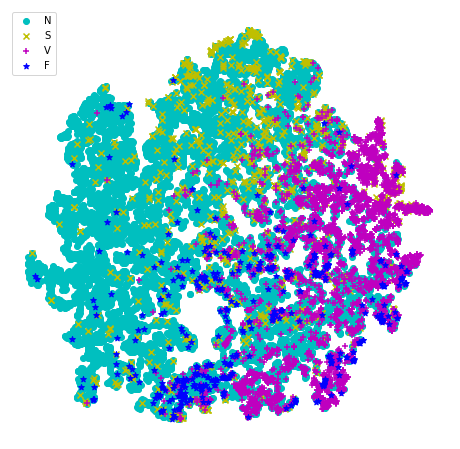

In [15]:
#visualize : t-SNE
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import random
def scatter(X, y):
    #X,y:numpy-array
    classes = len(list(set(y.tolist())))#get number of classes
    #palette = np.array(sns.color_palette("hls", classes))# choose a color palette with seaborn.
    color = ['c','y','m','b','g','r']
    marker = ['o','x','+','*','s']
    label = ['N','S','V','F']
    plt.figure(figsize=(8,8))#create a plot
    for i in range(classes):
        plt.scatter(X[y == i,0], X[y == i,1], c=color[i], marker=marker[i], label=label[i])
    plt.axis('off')
    plt.legend(loc='upper left')
    #plt.savefig('digits_tsne-generated.png', dpi=100)
    plt.show()

#prepare data，classes=5
#idx= random.sample(np.where(np.array(teY)==0)[0].tolist(),100)
idx= np.where(np.array(teY)==0)[0].tolist()
X0= np.array(teF)[idx]
y0= np.array(teY)[idx]

idx= np.where(np.array(teY)==1)[0].tolist()
X1= np.array(teF)[idx]
y1= np.array(teY)[idx]

idx= np.where(np.array(teY)==2)[0].tolist()
X2= np.array(teF)[idx]
y2= np.array(teY)[idx]

idx= np.where(np.array(teY)==3)[0].tolist()
X3= np.array(teF)[idx]
y3= np.array(teY)[idx]

y = np.append(y0,y1)
y = np.append(y,y2)
y = np.append(y,y3)
X = np.vstack((X0,X1))
X = np.vstack((X,X2))
X = np.vstack((X,X3))
#training t-sne 
tsne = TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(X)
print("Org data dimension is {}.Embedded data dimension is {}".format(X.shape[-1], X_tsne.shape[-1]))

#visualize
scatter(X_tsne, y)

In [8]:
# generate class activation mapping for the top1 prediction
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    
    output_cam = []
    for idx in class_idx:
        #cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc,h*w)))
        cam = weight_softmax[class_idx]*(feature_conv.reshape((nc,h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam


# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())
#last conv layer followed with one channel by last fully connected layer
final_conv = 'dense' 
best_net._modules.get(final_conv).register_forward_hook(hook_feature)
#get weights parameters
params = list(best_net.parameters())
#get the last and second last weights, like [classes, hiden nodes]
weight_softmax = np.squeeze(params[-2].data.cpu().numpy()) 
# define class type
classes = {0: 'N', 1: 'S', 2:'V', 3:'F'}
#read image
root='/data/fjsdata/ECG/MIT-BIH/test/9939-2.png'
img = []
img.append( cv2.resize(cv2.imread(root).astype(np.float32), (256, 256)))#(256, 256) is the model input size
data = torch.from_numpy(np.array(img)).type(torch.FloatTensor).cuda()
_,logit = best_net(data.permute(0, 3, 1, 2))#forword
h_x = F.softmax(logit, dim=1).data.squeeze()#softmax
probs, idx = h_x.sort(0, True) #probabilities of classes

# output: the prediction
for i in range(0, len(classes)):
    line = '{:.3f} -> {}'.format(probs[i], classes[idx[i].item()])
    print(line)
#get the class activation maps
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0].item()])

# render the CAM and show
print('output CAM.jpg for the top1 prediction: %s' % classes[idx[0].item()])
img = cv2.imread(root)
height, width, _ = img.shape
CAM = cv2.resize(CAMs[0], (width, height))
heatmap = cv2.applyColorMap(CAM, cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
cv2.imwrite('MIT-BIH_cam.jpg', result)

0.992 -> V
0.005 -> N
0.002 -> F
0.001 -> S
output CAM.jpg for the top1 prediction: V


True

In [7]:
#Baseline: DPSH-CVPR2015《Feature Learning based Deep Supervised Hashing with Pairwise Labels》
#https://github.com/TreezzZ/DPSH_PyTorch/blob/master/models/alexnet.py
class AlexNet(nn.Module):

    def __init__(self, code_length):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            #nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1024)
        )
        #self.classifier = self.classifier[:-1]
        self.hash_layer = nn.Linear(1024, code_length)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        x = self.hash_layer(x)
        return x
    
class HashLossFunc(nn.Module):
    def __init__(self, margin=0.5, alpha=0.01):
        super(HashLossFunc, self).__init__()
        self.alpha = alpha #regularization
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
        self.l1_loss = nn.L1Loss(reduction='mean')
    
    def forward(self,h1,h2,y):    
        margin_val = self.margin * h1.shape[1]
        squared_loss = torch.mean(self.mse_loss(h1, h2), dim=1)
        # T1: 0.5 * (1 - y) * dist(x1, x2)
        positive_pair_loss = (0.5 * (1 - y) * squared_loss)
        mean_positive_pair_loss = torch.mean(positive_pair_loss)
        # T2: 0.5 * y * max(margin - dist(x1, x2), 0)
        zeros = torch.zeros_like(squared_loss)
        marginMat = margin_val * torch.ones_like(squared_loss)
        negative_pair_loss = 0.5 * y * torch.max(zeros, marginMat - squared_loss)
        mean_negative_pair_loss = torch.mean(negative_pair_loss)

        # T3: alpha(dst_l1(abs(x1), 1)) + dist_l1(abs(x2), 1)))
        mean_value_regularization = self.alpha * (
                self.l1_loss(torch.abs(h1), torch.ones_like(h1)) +
                self.l1_loss(torch.abs(h2), torch.ones_like(h2)))

        loss = mean_positive_pair_loss + mean_negative_pair_loss + mean_value_regularization
        return loss

#Generate image pairs for model
def onlineGenImgPairs():
    if (len(trY) % 2) == 0: spls = len(trY)
    else:  spls = len(trY)-1
    idx_sf = random.sample(range(0, spls),spls)
    trI1_sf, trI2_sf, trY1_sf, trY2_sf = [],[],[],[]
    flag = 0
    for i in idx_sf:
        if flag==0:
            trI1_sf.append(trI[i])
            trY1_sf.append(trY[i])
            flag =1
        else:
            trI2_sf.append(trI[i])
            trY2_sf.append(trY[i])
            flag =0
    trY_sf = np.where((np.array(trY1_sf)-np.array(trY2_sf))!=0,1,0)
    return np.array(trI1_sf),np.array(trI2_sf),trY_sf
#define model
model = AlexNet(code_length=36).cuda()
criterion  = HashLossFunc(margin=0.5).cuda() #define loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    trI1_sf, trI2_sf, trY_sf = onlineGenImgPairs()
    num_batches = len(trY_sf) // batchSize 
    losses = []
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY_sf), (i+1)*batchSize])
        I1_batch = torch.from_numpy(trI1_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        I2_batch = torch.from_numpy(trI2_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Y_batch = torch.from_numpy(trY_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        #forword
        X1_batch = model(I1_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        X2_batch = model(I2_batch.permute(0, 3, 1, 2))
        #binary-like loss
        loss = criterion(X1_batch,X2_batch,Y_batch)
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
loss = loss.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teF = []
num_batches = len(teI) // batchSize
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(teI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    teF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(36) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
for topk in [10]:#[5,10,15,20]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    scores, neighbors = gpu_index.search(np.array(teF).astype('float32'), k=topk)
    for i, teVal in enumerate(teF):
        stype = teY[i]
        #map_item_score = {}
        #for j, trVal in enumerate(trF):
        #    map_item_score[j] = pdist(np.vstack([teVal,trVal]),'hamming')
        #ranklist = heapq.nsmallest(topk, map_item_score, key=map_item_score.get)
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        #for j in ranklist:
        for j in neighbors[i].tolist():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))
#performance
scores, neighbors = gpu_index.search(np.ascontiguousarray(teF, dtype=np.float32), k=1) #return top1
y_pred = []
for i in neighbors.flatten():
    y_pred.append(np.array(trY)[i]) #label of top1
print ( 'Accuracy: %.6f'%accuracy_score(teY, y_pred))
labels = list(set(teY))
cm = confusion_matrix(teY, y_pred, labels=labels ) #labels=['S','V','F','N']
print (cm)
print ('Specificity of N: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of V: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of F: %.6f'%float(cm[3][3]/np.sum(cm[3])))

 1000 / 1000 : loss = 5.400259Eopch:     1 mean_loss = 11.807709
 1000 / 1000 : loss = 6.30002Eopch:     2 mean_loss = 3.907000
 1000 / 1000 : loss = 1.800013Eopch:     3 mean_loss = 3.897013
 1000 / 1000 : loss = 7.200014Eopch:     4 mean_loss = 3.902412
 1000 / 1000 : loss = 6.300012Eopch:     5 mean_loss = 3.985212
 1000 / 1000 : loss = 1.800011Eopch:     6 mean_loss = 3.942012
 1000 / 1000 : loss = 4.50001Eopch:     7 mean_loss = 3.915012
 1000 / 1000 : loss = 6.300014Eopch:     8 mean_loss = 3.911413
 1000 / 1000 : loss = 3.600015Eopch:     9 mean_loss = 3.932114
 1000 / 1000 : loss = 3.600021Eopch:    10 mean_loss = 3.881716
best_loss = 3.881716
 1999 / 2000 Completed buliding index in 23 seconds
mHR@10=0.521380, mAP@10=0.381041, mRR@10=0.864535
Accuracy: 0.742700
[[14854     0     0     0]
 [  944     0     0     0]
 [ 3788     0     0     0]
 [  414     0     0     0]]
Specificity of N: 1.000000
Sensitivity of S: 0.000000
Sensitivity of V: 0.000000
Sensitivity of F: 0.000000


In [8]:
#Baseline: DRH-MICCAI2017《Hashing with Residual Networks for Image Retrieval》
#https://github.com/dansuh17/deep-supervised-hashing
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ResNet(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.net = nn.Sequential(
            ResBlock(in_channels=3, out_channels=16),
            ResBlock(in_channels=16, out_channels=16),
            ResBlock(in_channels=16, out_channels=16, stride=2),
        )
        self.linear_input_size = 16*128*128
        self.linear = nn.Linear(self.linear_input_size, num_classes)

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.net(x)
        x = x.view(-1, self.linear_input_size)
        return self.linear(x)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class DRH(nn.Module):
    def __init__(self, code_size: int):
        super().__init__()
        resnet = ResNet(num_classes=10)
        resnet.linear = nn.Linear(in_features=resnet.linear_input_size, out_features=code_size)
        self.net = resnet

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        return self.net(x)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
    
class HashLossFunc(nn.Module):
    def __init__(self, margin=0.5, alpha=0.01):
        super(HashLossFunc, self).__init__()
        self.alpha = alpha #regularization
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
        self.l1_loss = nn.L1Loss(reduction='mean')
    
    def forward(self,h1,h2,y):    
        margin_val = self.margin * h1.shape[1]
        squared_loss = torch.mean(self.mse_loss(h1, h2), dim=1)
        # T1: 0.5 * (1 - y) * dist(x1, x2)
        positive_pair_loss = (0.5 * (1 - y) * squared_loss)
        mean_positive_pair_loss = torch.mean(positive_pair_loss)
        # T2: 0.5 * y * max(margin - dist(x1, x2), 0)
        zeros = torch.zeros_like(squared_loss)
        marginMat = margin_val * torch.ones_like(squared_loss)
        negative_pair_loss = 0.5 * y * torch.max(zeros, marginMat - squared_loss)
        mean_negative_pair_loss = torch.mean(negative_pair_loss)

        # T3: alpha(dst_l1(abs(x1), 1)) + dist_l1(abs(x2), 1)))
        mean_value_regularization = self.alpha * (
                self.l1_loss(torch.abs(h1), torch.ones_like(h1)) +
                self.l1_loss(torch.abs(h2), torch.ones_like(h2)))

        loss = mean_positive_pair_loss + mean_negative_pair_loss + mean_value_regularization
        return loss

#Generate image pairs for model
def onlineGenImgPairs():
    if (len(trY) % 2) == 0: spls = len(trY)
    else:  spls = len(trY)-1
    idx_sf = random.sample(range(0, spls),spls)
    trI1_sf, trI2_sf, trY1_sf, trY2_sf = [],[],[],[]
    flag = 0
    for i in idx_sf:
        if flag==0:
            trI1_sf.append(trI[i])
            trY1_sf.append(trY[i])
            flag =1
        else:
            trI2_sf.append(trI[i])
            trY2_sf.append(trY[i])
            flag =0
    trY_sf = np.where((np.array(trY1_sf)-np.array(trY2_sf))!=0,1,0)
    return np.array(trI1_sf),np.array(trI2_sf),trY_sf
#define model
model = DRH(code_size=36).cuda()
criterion  = HashLossFunc(margin=0.5).cuda() #define loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    trI1_sf, trI2_sf, trY_sf = onlineGenImgPairs()
    num_batches = len(trY_sf) // batchSize 
    losses = []
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY_sf), (i+1)*batchSize])
        I1_batch = torch.from_numpy(trI1_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        I2_batch = torch.from_numpy(trI2_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Y_batch = torch.from_numpy(trY_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        #forword
        X1_batch = model(I1_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        X2_batch = model(I2_batch.permute(0, 3, 1, 2))
        #binary-like loss
        loss = criterion(X1_batch,X2_batch,Y_batch)
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
loss = loss.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teF = []
num_batches = len(teI) // batchSize
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(teI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    teF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(36) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
for topk in [10]:#[5,10,15,20]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    scores, neighbors = gpu_index.search(np.array(teF).astype('float32'), k=topk)
    for i, teVal in enumerate(teF):
        stype = teY[i]
        #map_item_score = {}
        #for j, trVal in enumerate(trF):
        #    map_item_score[j] = pdist(np.vstack([teVal,trVal]),'hamming')
        #ranklist = heapq.nsmallest(topk, map_item_score, key=map_item_score.get)
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        #for j in ranklist:
        for j in neighbors[i].tolist():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))
#performance
scores, neighbors = gpu_index.search(np.ascontiguousarray(teF, dtype=np.float32), k=1) #return top1
y_pred = []
for i in neighbors.flatten():
    y_pred.append(np.array(trY)[i]) #label of top1
print ( 'Accuracy: %.6f'%accuracy_score(teY, y_pred))
labels = list(set(teY))
cm = confusion_matrix(teY, y_pred, labels=labels ) #labels=['S','V','F','N']
print (cm)
print ('Specificity of N: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of V: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of F: %.6f'%float(cm[3][3]/np.sum(cm[3])))

 1000 / 1000 : loss = 1.588184Eopch:     1 mean_loss = 1.119676
 1000 / 1000 : loss = 0.379761Eopch:     2 mean_loss = 0.759607
 1000 / 1000 : loss = 1.816798Eopch:     3 mean_loss = 0.666999
 1000 / 1000 : loss = 0.676921Eopch:     4 mean_loss = 0.602044
 1000 / 1000 : loss = 0.351152Eopch:     5 mean_loss = 0.540338
 1000 / 1000 : loss = 0.885358Eopch:     6 mean_loss = 0.515613
 1000 / 1000 : loss = 0.239584Eopch:     7 mean_loss = 0.473548
 1000 / 1000 : loss = 0.556354Eopch:     8 mean_loss = 0.412297
 1000 / 1000 : loss = 0.114756Eopch:     9 mean_loss = 0.385732
 1000 / 1000 : loss = 0.442873Eopch:    10 mean_loss = 0.333566
best_loss = 0.333566
 1999 / 2000 Completed buliding index in 1 seconds
mHR@10=0.743435, mAP@10=0.721871, mRR@10=0.942841
Accuracy: 0.742000
[[11173   531  3042   108]
 [  526   134   278     6]
 [  157    70  3509    52]
 [  239     3   148    24]]
Specificity of N: 0.752188
Sensitivity of S: 0.141949
Sensitivity of V: 0.926346
Sensitivity of F: 0.057971


In [11]:
#Baseline: DSH:ACCV2016《deep supervised hashing with triplet labels》
#https://github.com/weixu000/DSH-pytorch/blob/master/model.py
class DSH(nn.Module):
    def __init__(self, num_binary):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),  # same padding
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(32, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=3, stride=2),

            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=3, stride=2),
        )
        self.fc = nn.Sequential(
            nn.Linear(64*31*31, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, num_binary)
        )

        for m in self.modules():
            if m.__class__ == nn.Conv2d or m.__class__ == nn.Linear:
                nn.init.xavier_normal(m.weight.data)
                m.bias.data.fill_(0)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

#https://github.com/luyajie/triplet-deep-hash-pytorch#triplet-deep-hash-pytorch            
class TripletLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(TripletLoss, self).__init__()
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
    
    def forward(self,H_q,H_p,H_n):    
        margin_val = self.margin * H_q.shape[1]
        squared_loss_pos = torch.mean(self.mse_loss(H_q, H_p), dim=1)
        squared_loss_neg = torch.mean(self.mse_loss(H_q, H_n), dim=1)
        zeros = torch.zeros_like(squared_loss_neg)
        loss  = torch.max(zeros, margin_val - squared_loss_neg + squared_loss_pos)
        return torch.mean(loss)

#Generate image pairs for model
def onlineGenImgPairs( ):
    idx_sf = []
    idx_0 = np.where( np.array(trY) == 0 ) #class 0
    idx_0 = list(idx_0[0])
    idx_sf.extend(idx_0)
    idx_1 = np.where( np.array(trY) == 1 ) #class 1
    idx_1 = list(idx_1[0])
    idx_sf.extend(idx_1)
    idx_2 = np.where( np.array(trY) == 2 ) #class 2
    idx_2 = list(idx_2[0])
    idx_sf.extend(idx_2)
    idx_3 = np.where( np.array(trY) == 3 ) #class 3
    idx_3 = list(idx_3[0])
    idx_sf.extend(idx_3)
    idx_4 = np.where( np.array(trY) == 4 ) #class 4
    idx_4 = list(idx_4[0])#[0:993]
    idx_sf.extend(idx_4)
    random.shuffle(idx_sf)   
    trQ_sf, trP_sf, trN_sf = [], [], []
    for iQ in idx_sf:
        trQ_sf.append(trI[iQ])
        if trY[iQ] == 0:
            idx_tmp = idx_0.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_0))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
        elif trY[iQ] == 1:
            idx_tmp = idx_1.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_1))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
        elif trY[iQ] == 2:
            idx_tmp = idx_2.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_2))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
        elif trY[iQ] == 3:
            idx_tmp = idx_3.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_3))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
        elif trY[iQ] == 4:
            idx_tmp = idx_4.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_4))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
        else: pass
        sys.stdout.write('\r{} / {} '.format(len(trQ_sf),len(idx_sf)))
        sys.stdout.flush()
    return np.array(trQ_sf),np.array(trP_sf),np.array(trN_sf)
#trQ_sf, trP_sf, trN_sf = onlineGenImgPairs() #sample 
assert (trQ_sf.shape==trP_sf.shape)
assert (trQ_sf.shape==trN_sf.shape)

#define model
model = DSH(num_binary=36).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
criterion  = TripletLoss(margin=0.5).cuda() #define TripletLoss 
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    losses = []
    shuffled_idx = np.random.permutation(np.arange(len(trQ_sf)))
    train_q = trQ_sf[shuffled_idx]
    train_p = trP_sf[shuffled_idx]
    train_n = trN_sf[shuffled_idx]
    #trQ_sf, trP_sf, trN_sf = onlineGenImgPairs()
    num_batches = len(trQ_sf) // batchSize
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trQ_sf), (i+1)*batchSize])
        Q_batch = torch.from_numpy(train_q[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        P_batch = torch.from_numpy(train_p[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        N_batch = torch.from_numpy(train_n[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        #forword
        Q_hash = model(Q_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        P_hash = model(P_batch.permute(0, 3, 1, 2))
        N_hash = model(N_batch.permute(0, 3, 1, 2))
        #binary-like loss
        loss = criterion(Q_hash,P_hash,N_hash)
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
criterion=criterion.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teF = []
num_batches = len(teI) // batchSize 
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(teI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    teF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(36) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
for topk in [10]:#[5,10,15,20]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    scores, neighbors = gpu_index.search(np.array(teF).astype('float32'), k=topk)
    for i, teVal in enumerate(teF):
        stype = teY[i]
        #map_item_score = {}
        #for j, trVal in enumerate(trF):
        #    map_item_score[j] = pdist(np.vstack([teVal,trVal]),'hamming')
        #ranklist = heapq.nsmallest(topk, map_item_score, key=map_item_score.get)
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        #for j in ranklist:
        for j in neighbors[i].tolist():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))
    
#performance
scores, neighbors = gpu_index.search(np.ascontiguousarray(teF, dtype=np.float32), k=1) #return top1
y_pred = []
for i in neighbors.flatten():
    y_pred.append(np.array(trY)[i]) #label of top1
print ( 'Accuracy: %.6f'%accuracy_score(teY, y_pred))
labels = list(set(teY))
cm = confusion_matrix(teY, y_pred, labels=labels )  #labels=['S','V','F','N']
print (cm)
print ('Specificity of N: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of V: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of F: %.6f'%float(cm[3][3]/np.sum(cm[3])))

/root/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


 2000 / 2000 : loss = 23.4027654Eopch:     1 mean_loss = 4.519288
 2000 / 2000 : loss = 3.2366725Eopch:     2 mean_loss = 2.409906
 2000 / 2000 : loss = 9.9310733Eopch:     3 mean_loss = 2.353988
 2000 / 2000 : loss = 8.1860481Eopch:     4 mean_loss = 1.948102
 2000 / 2000 : loss = 0.0067886Eopch:     5 mean_loss = 1.738725
 2000 / 2000 : loss = 0.0314959Eopch:     6 mean_loss = 1.738114
 2000 / 2000 : loss = 0.0936078Eopch:     7 mean_loss = 1.646276
 2000 / 2000 : loss = 2.7946174Eopch:     8 mean_loss = 1.476853
 2000 / 2000 : loss = 0.0367874Eopch:     9 mean_loss = 1.331165
 2000 / 2000 : loss = 0.0334413Eopch:    10 mean_loss = 1.358452
best_loss = 1.331165
 1999 / 2000 Completed buliding index in 1 seconds
mHR@10=0.786180, mAP@10=0.757461, mRR@10=0.925397
Accuracy: 0.778500
[[11949   279  2429   197]
 [  556   172   209     7]
 [  251    93  3429    15]
 [  277     3   114    20]]


IndexError: index 4 is out of bounds for axis 0 with size 4

In [12]:
print ('Specificity of N: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of V: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of F: %.6f'%float(cm[3][3]/np.sum(cm[3])))

Specificity of N: 0.804430
Sensitivity of S: 0.182203
Sensitivity of V: 0.905227
Sensitivity of F: 0.048309


In [7]:
#baseline: CVPR2016《Fast Training of Triplet-based Deep Binary Embedding Networks》
#https://github.com/luyajie/triplet-deep-hash-pytorch#triplet-deep-hash-pytorch
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ResNet(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.net = nn.Sequential(
            ResBlock(in_channels=3, out_channels=16),
            ResBlock(in_channels=16, out_channels=16),
            ResBlock(in_channels=16, out_channels=16, stride=2),
        )
        self.linear_input_size = 16*128*128
        self.linear = nn.Linear(self.linear_input_size, num_classes)

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x1,x2,y):
        x1 = self.net(x1)
        x1 = x1.view(-1, self.linear_input_size)
        x1 = self.linear(x1)
        x2 = self.net(x2)
        x2 = x2.view(-1, self.linear_input_size)
        x2 = self.linear(x2)
        y = self.net(y)
        y = y.view(-1, self.linear_input_size)
        y = self.linear(y)
        return x1, x2, y

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
        
#Generate image pairs for model
def onlineGenImgPairs( ):
    idx_sf = []
    idx_0 = np.where( np.array(trY) == 0 ) #class 0
    idx_0 = list(idx_0[0])
    idx_sf.extend(idx_0)
    idx_1 = np.where( np.array(trY) == 1 ) #class 1
    idx_1 = list(idx_1[0])
    idx_sf.extend(idx_1)
    idx_2 = np.where( np.array(trY) == 2 ) #class 2
    idx_2 = list(idx_2[0])
    idx_sf.extend(idx_2)
    idx_3 = np.where( np.array(trY) == 3 ) #class 3
    idx_3 = list(idx_3[0])
    idx_sf.extend(idx_3)
    idx_4 = np.where( np.array(trY) == 4 ) #class 4
    idx_4 = list(idx_4[0])#[0:993]
    idx_sf.extend(idx_4)
    random.shuffle(idx_sf)   
    trQ_sf, trP_sf, trN_sf = [], [], []
    for iQ in idx_sf:
        trQ_sf.append(trI[iQ])
        if trY[iQ] == 0:
            idx_tmp = idx_0.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_0))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
        elif trY[iQ] == 1:
            idx_tmp = idx_1.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_1))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
        elif trY[iQ] == 2:
            idx_tmp = idx_2.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_2))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
        elif trY[iQ] == 3:
            idx_tmp = idx_3.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_3))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
        elif trY[iQ] == 4:
            idx_tmp = idx_4.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_4))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
        else: pass
        sys.stdout.write('\r{} / {} '.format(len(trQ_sf),len(idx_sf)))
        sys.stdout.flush()
    return np.array(trQ_sf),np.array(trP_sf),np.array(trN_sf)
#trQ_sf, trP_sf, trN_sf = onlineGenImgPairs() #sample 
assert (trQ_sf.shape==trP_sf.shape)
assert (trQ_sf.shape==trN_sf.shape)

#define model
model = ResNet(num_classes=36).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
pdist = nn.PairwiseDistance(2)
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    losses = []
    shuffled_idx = np.random.permutation(np.arange(len(trQ_sf)))
    train_q = trQ_sf[shuffled_idx]
    train_p = trP_sf[shuffled_idx]
    train_n = trN_sf[shuffled_idx]
    #trQ_sf, trP_sf, trN_sf = onlineGenImgPairs()
    num_batches = len(trQ_sf) // batchSize
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trQ_sf), (i+1)*batchSize])
        Q_batch = torch.from_numpy(train_q[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        P_batch = torch.from_numpy(train_p[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        N_batch = torch.from_numpy(train_n[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        #forword
        Q_hash, P_hash, N_hash = model(Q_batch.permute(0, 3, 1, 2), P_batch.permute(0, 3, 1, 2), N_batch.permute(0, 3, 1, 2))
        #binary-like loss
        loss1 = pdist(Q_hash, P_hash)
        loss2 = pdist(Q_hash, N_hash)
        l = 18 - loss2 + loss1
        loss = torch.mean(F.relu(l))
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
#criterion=criterion.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch,_,_ = best_net(I_batch.permute(0, 3, 1, 2), I_batch.permute(0, 3, 1, 2), I_batch.permute(0, 3, 1, 2))
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teF = []
num_batches = len(teI) // batchSize 
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(teI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch,_,_ = best_net(I_batch.permute(0, 3, 1, 2), I_batch.permute(0, 3, 1, 2), I_batch.permute(0, 3, 1, 2))
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    teF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(36) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
for topk in [10]:#[5,10,15,20]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    scores, neighbors = gpu_index.search(np.array(teF).astype('float32'), k=topk)
    for i, teVal in enumerate(teF):
        stype = teY[i]
        #map_item_score = {}
        #for j, trVal in enumerate(trF):
        #    map_item_score[j] = pdist(np.vstack([teVal,trVal]),'hamming')
        #ranklist = heapq.nsmallest(topk, map_item_score, key=map_item_score.get)
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        #for j in ranklist:
        for j in neighbors[i].tolist():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))
    
#performance
scores, neighbors = gpu_index.search(np.ascontiguousarray(teF, dtype=np.float32), k=1) #return top1
y_pred = []
for i in neighbors.flatten():
    y_pred.append(np.array(trY)[i]) #label of top1
print ( 'Accuracy: %.6f'%accuracy_score(teY, y_pred))
labels = list(set(teY))
cm = confusion_matrix(teY, y_pred, labels=labels ) ##labels=['S','V','F','N']
print (cm)
print ('Specificity of N: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of V: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of F: %.6f'%float(cm[3][3]/np.sum(cm[3])))

 2000 / 2000 : loss = 2.9687638Eopch:     1 mean_loss = 1.199118
 2000 / 2000 : loss = 0.0278813Eopch:     2 mean_loss = 0.479434
 2000 / 2000 : loss = 0.0566219Eopch:     3 mean_loss = 0.257117
 2000 / 2000 : loss = 4.293497Eopch:     4 mean_loss = 0.174655
 2000 / 2000 : loss = 0.006984Eopch:     5 mean_loss = 0.132593
 2000 / 2000 : loss = 0.092844Eopch:     6 mean_loss = 0.102133
 2000 / 2000 : loss = 0.059761Eopch:     7 mean_loss = 0.094602
 2000 / 2000 : loss = 0.081019Eopch:     8 mean_loss = 0.075977
 2000 / 2000 : loss = 0.064319Eopch:     9 mean_loss = 0.065631
 2000 / 2000 : loss = 0.041695Eopch:    10 mean_loss = 0.061643
best_loss = 0.061643
 1999 / 2000 Completed buliding index in 25 seconds
mHR@10=0.753585, mAP@10=0.736059, mRR@10=0.945661
Accuracy: 0.754750
[[11510   219  3035    90]
 [  491   189   263     1]
 [  326    37  3395    30]
 [  255     5   153     1]]
Specificity of N: 0.774875
Sensitivity of S: 0.200212
Sensitivity of V: 0.896251
Sensitivity of F: 0.00241

In [9]:
#release gpu memory
model = model.cpu()
torch.cuda.empty_cache()